In [1]:
!pip -q install torch torchvision torchaudio

In [2]:
import torch, torchvision, matplotlib
print(torch.__version__, torchvision.__version__, torch.cuda.is_available())

2.8.0+cu126 0.23.0+cu126 False


In [17]:
import math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [7]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [8]:
# Each image is 28x28 grayscale. We normalize pixel values for faster learning.
transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor in range [0,1]
    transforms.Normalize((0.1307,), (0.3081,))# Center and scale using MNIST mean/std
])

# Download the train and test sets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create loaders that feed data in small batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


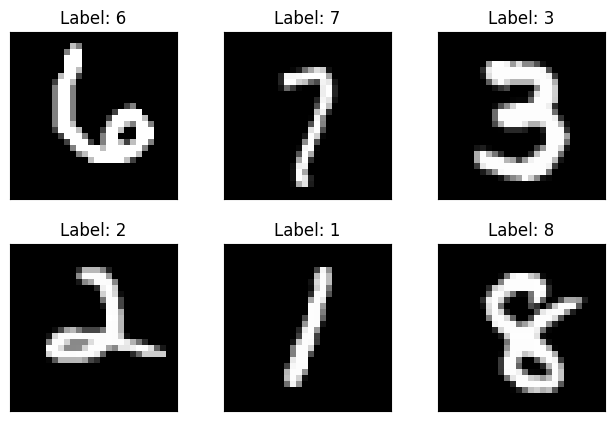

In [14]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([]); plt.yticks([])
plt.show()


In [35]:
class SimpleMLP(nn.Module):
  def __init__(self):
    super(SimpleMLP, self).__init__()

    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64, 10)


  def forward(self, x):

    x= x.view(-1,28*28)

    x= F.sigmoid(self.fc1(x))
    x= F.sigmoid(self.fc2(x))
    x= self.fc3(x)

    return x

In [36]:
model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [25]:
epochs = 5

for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for batch_idx, (data, targets) in enumerate(train_loader):
    data, targets = data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss +=loss.item()
    if batch_idx % 100 == 0:
      print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.4f}")

print(f"Epoch {epoch+1} completed, average loss: {running_loss/len(train_loader):.4f}")


Epoch 1 [0/60000]  Loss: 2.2719
Epoch 1 [6400/60000]  Loss: 0.4417
Epoch 1 [12800/60000]  Loss: 0.3336
Epoch 1 [19200/60000]  Loss: 0.3932
Epoch 1 [25600/60000]  Loss: 0.2300
Epoch 1 [32000/60000]  Loss: 0.1301
Epoch 1 [38400/60000]  Loss: 0.1931
Epoch 1 [44800/60000]  Loss: 0.2583
Epoch 1 [51200/60000]  Loss: 0.0986
Epoch 1 [57600/60000]  Loss: 0.1825
Epoch 2 [0/60000]  Loss: 0.1393
Epoch 2 [6400/60000]  Loss: 0.0456
Epoch 2 [12800/60000]  Loss: 0.2048
Epoch 2 [19200/60000]  Loss: 0.1188
Epoch 2 [25600/60000]  Loss: 0.0232
Epoch 2 [32000/60000]  Loss: 0.0489
Epoch 2 [38400/60000]  Loss: 0.0592
Epoch 2 [44800/60000]  Loss: 0.0335
Epoch 2 [51200/60000]  Loss: 0.0662
Epoch 2 [57600/60000]  Loss: 0.0277
Epoch 3 [0/60000]  Loss: 0.0297
Epoch 3 [6400/60000]  Loss: 0.1168
Epoch 3 [12800/60000]  Loss: 0.0225
Epoch 3 [19200/60000]  Loss: 0.0972
Epoch 3 [25600/60000]  Loss: 0.0629
Epoch 3 [32000/60000]  Loss: 0.0255
Epoch 3 [38400/60000]  Loss: 0.0106
Epoch 3 [44800/60000]  Loss: 0.0418
Epoch 3

In [26]:
model.eval()                    # Turn off training-specific layers
correct = 0
total = 0

with torch.no_grad():           # Disable gradient tracking
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)   # Highest logit = predicted class
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 97.68%


Epoch 1, Loss: 0.5685
Epoch 2, Loss: 0.1743
Epoch 3, Loss: 0.1165
Epoch 4, Loss: 0.0863
Epoch 5, Loss: 0.0662


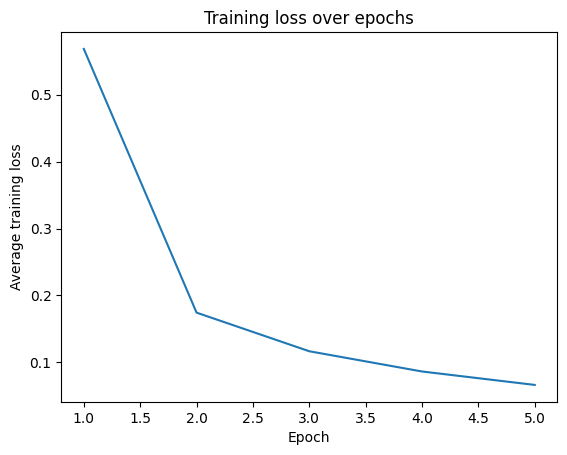

In [37]:
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


plt.plot(range(1, epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Average training loss')
plt.title('Training loss over epochs')
plt.show()


In [38]:
# Example: store both train and test losses each epoch
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Evaluate on test set ---
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {accuracy:.2f}%")


Epoch 1, Train Loss: 0.0515, Test Loss: 0.0850, Test Acc: 97.50%
Epoch 2, Train Loss: 0.0410, Test Loss: 0.0859, Test Acc: 97.33%
Epoch 3, Train Loss: 0.0327, Test Loss: 0.0776, Test Acc: 97.67%
Epoch 4, Train Loss: 0.0253, Test Loss: 0.0791, Test Acc: 97.58%
Epoch 5, Train Loss: 0.0220, Test Loss: 0.0783, Test Acc: 97.66%


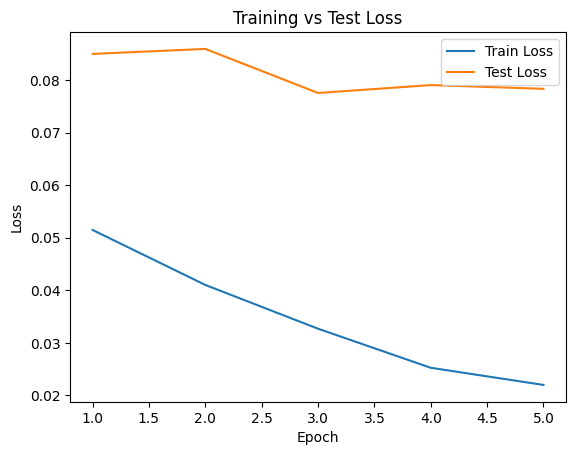

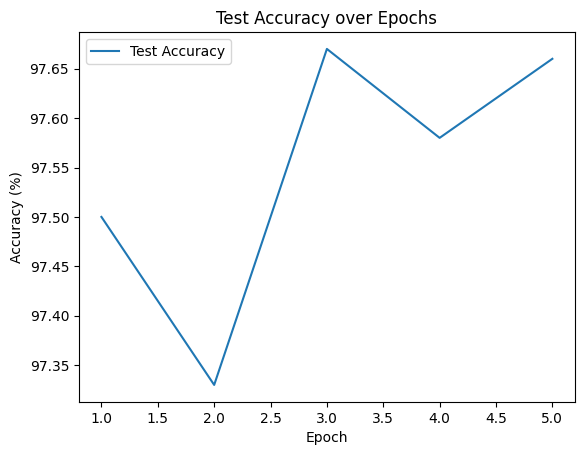

In [39]:
# Plot training and test loss
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.show()

# Plot test accuracy
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()
